# Pós Tech Challenge FIAP - Fase 1

Este notebook apresenta o desenvolvimento de um modelo preditivo de regressão para estimar os custos médicos individuais cobrados pelo seguro de saúde, conforme desafio proposto na Fase 1 do Pós Tech da FIAP.

**Integrantes do grupo:**
- Carlos Adriano
- Daniel Kiluange
- Leonardo Nogueira

O passo a passo inclui:
- Carregamento e exploração dos dados
- Pré-processamento e tratamento de valores ausentes
- Conversão de variáveis categóricas
- Visualização exploratória
- Separação dos dados em treino e teste
- Treinamento do modelo de regressão linear
- Avaliação e visualização dos resultados

O objetivo é construir um modelo capaz de prever os encargos médicos a partir das características dos clientes, utilizando técnicas de aprendizado supervisionado.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import alpha

In [2]:
# Carregando o dataset
raw_dataset = pd.read_csv('seguro_saude_dataset_2.csv')

In [4]:
# Verificando se o dataset possui valores nulos e exibindo informações gerais
print(raw_dataset.info())
print(raw_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   idade     100000 non-null  int64  
 1   genero    100000 non-null  object 
 2   imc       100000 non-null  float64
 3   fumante   100000 non-null  object 
 4   regiao    100000 non-null  object 
 5   encargos  100000 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB
None
idade       0
genero      0
imc         0
fumante     0
regiao      0
encargos    0
dtype: int64


In [3]:
num_dataset = raw_dataset.copy()

In [5]:
# Substituindo os valores binários de 'genero' e 'fumante' por 0 e 1 e separando a coluna 'regiao' em novas colunas binárias

num_dataset['regiao'] = (
    num_dataset['regiao'].map({'norte': 1, 'nordeste': 2, 'centro-oeste': 3, 'sudeste': 4, 'sul': 5}))

In [6]:
num_dataset['genero'] = num_dataset['genero'].map({'masculino': 0, 'feminino': 1})
num_dataset['fumante'] = num_dataset['fumante'].map({'não': 0, 'sim': 1})
num_dataset.head()

,idade,genero,imc,fumante,regiao,encargos
0,56,0,24.54,0,4,9816.22
1,69,0,18.24,1,2,21870.06
2,46,1,26.23,0,1,6969.30
3,32,0,19.08,0,4,6603.50
4,60,0,25.64,0,4,8780.76


In [ ]:
import seaborn as sns

#Exibindo gráficos de dispersão geral do dataset separados por gênero
sns.pairplot(data=num_dataset, hue='genero', vars=['idade', 'imc', 'fumante', 'encargos', 'regiao'])

In [7]:
X = num_dataset[['idade', 'imc', 'genero', 'fumante', 'regiao']]
y = num_dataset['encargos']

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Create preprocessing steps
numeric_features = ['idade', 'imc']
categorical_features = ['genero', 'fumante', 'regiao']


# Define custom scaling functions with weights
def weighted_numeric_scaler(weight):
    def scaler(X):
        return StandardScaler().fit_transform(X) * weight

    return FunctionTransformer(scaler)


def weighted_categorical_scaler(weight):
    def scaler(X):
        return OneHotEncoder(drop='first', sparse_output=False).fit_transform(X) * weight

    return FunctionTransformer(scaler)

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

weighted_preprocessor = ColumnTransformer(
    transformers=[
        # Adjust these weights based on your needs
        ('num', make_pipeline(
            StandardScaler(),
            FunctionTransformer(lambda x: x * 0.3)  # Numeric features weight
        ), numeric_features),
        ('cat', make_pipeline(
            OneHotEncoder(drop='first', sparse_output=False),
            FunctionTransformer(lambda x: x * 0.7)  # Categorical features weight
        ), categorical_features)
    ])


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def evaluate_model(y_true, y_pred):
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name} model...")

    pipeline = Pipeline([
        ('preprocessor', weighted_preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)

    train_predictions = pipeline.predict(X_train)
    test_predictions = pipeline.predict(X_test)

    train_metrics = evaluate_model(y_train, train_predictions)
    test_metrics = evaluate_model(y_test, test_predictions)

    print(f"Métricas no conjunto de treino:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print(f"Métricas no conjunto de teste:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    results[name] = {
        'pipeline': pipeline,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }




# create a pipeline object



Training Linear Regression model...
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.8072
  RMSE: 1113.2222
  MAPE: 10.0519
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3545
  RMSE: 1116.5228
  MAPE: 10.1160
Training Ridge Regression model...
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.7949
  RMSE: 1113.2231
  MAPE: 10.0520
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3455
  RMSE: 1116.5320
  MAPE: 10.1161
Training Lasso Regression model...
Métricas no conjunto de treino:
  R²: 0.9657
  MAE: 883.7713
  RMSE: 1113.2244
  MAPE: 10.0508
Métricas no conjunto de teste:
  R²: 0.9656
  MAE: 890.3389
  RMSE: 1116.5452
  MAPE: 10.1151
Training Random Forest model...
Métricas no conjunto de treino:
  R²: 0.9940
  MAE: 361.4443
  RMSE: 467.2546
  MAPE: 4.2219
Métricas no conjunto de teste:
  R²: 0.9627
  MAE: 927.4510
  RMSE: 1163.5022
  MAPE: 10.8255
Training Gradient Boosting model...
Métricas no conjunto de treino:
  R²: 0.9699
  MAE: 831.3592
  RMSE: 104

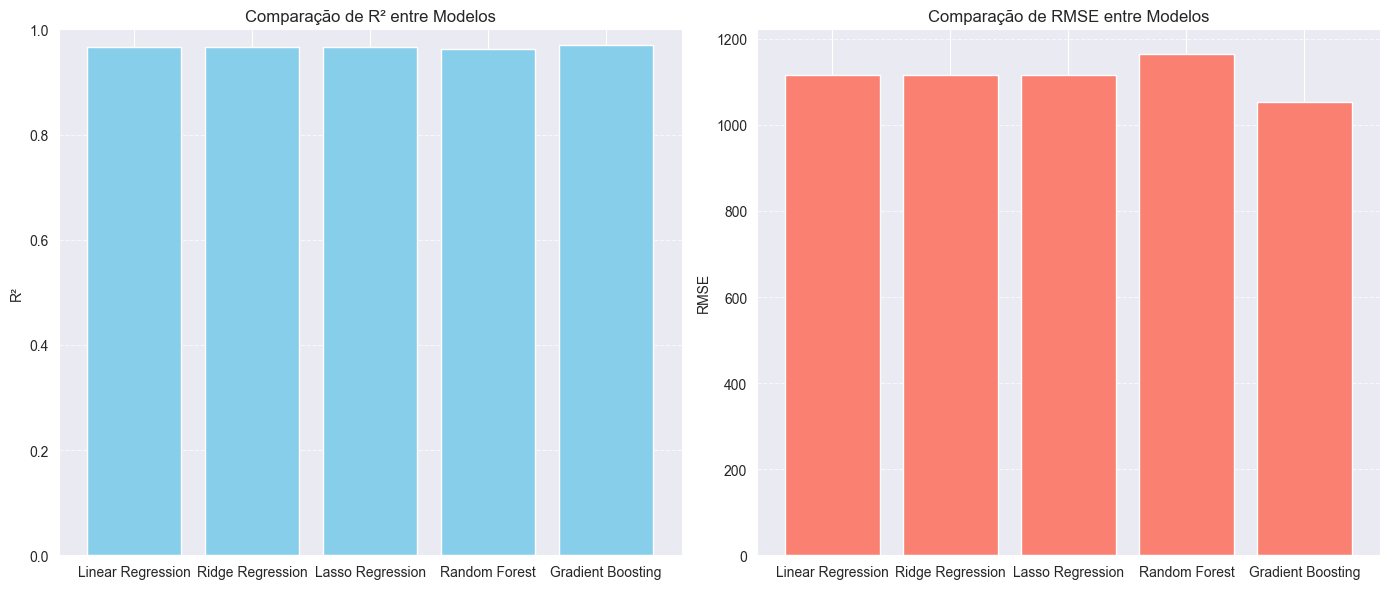


Melhor modelo: Gradient Boosting
R² no conjunto de teste: 0.9694
RMSE no conjunto de teste: 1053.4406


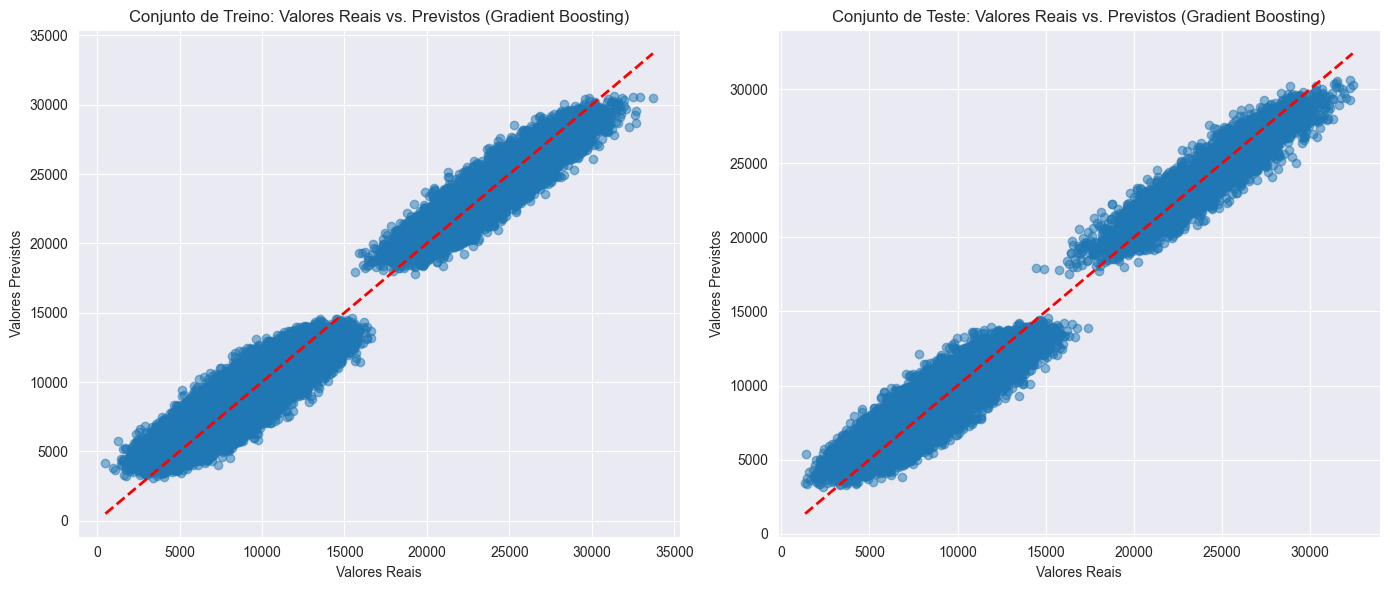

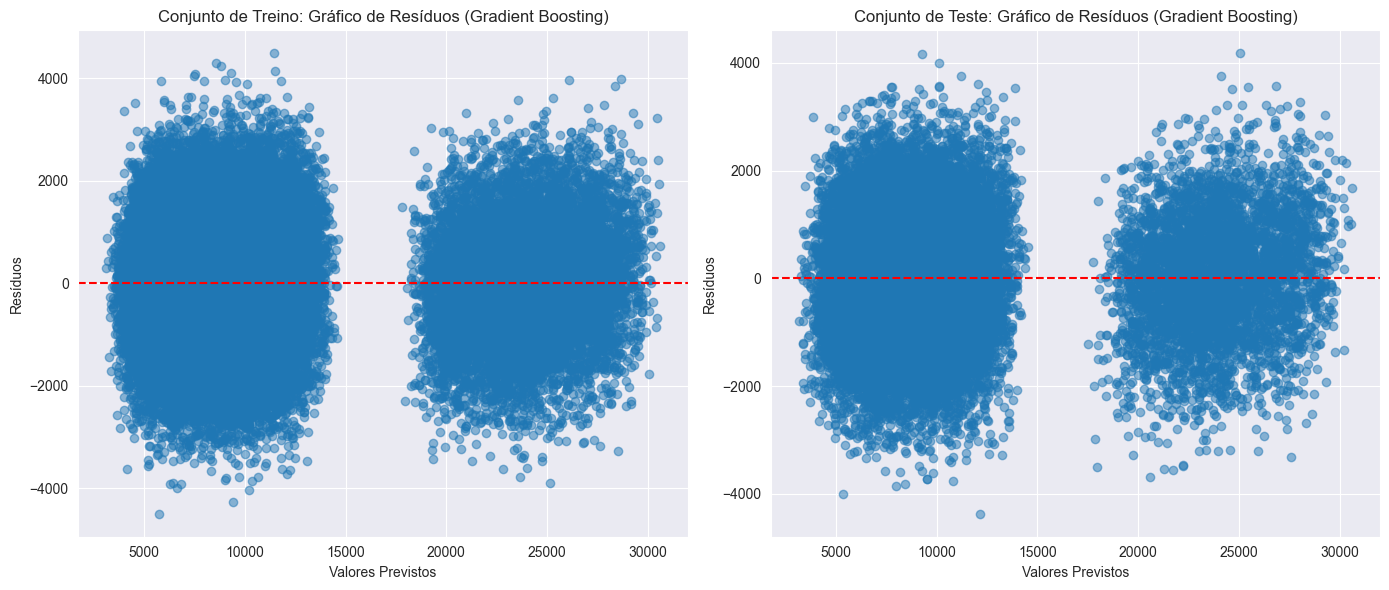

In [15]:
from matplotlib import pyplot as plt
# Visualização dos resultados
def visualize_model_results(results):
    # Comparação de métricas entre modelos
    model_names = list(results.keys())
    r2_scores = [results[name]['test_metrics']['R²'] for name in model_names]
    rmse_scores = [results[name]['test_metrics']['RMSE'] for name in model_names]

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].bar(model_names, r2_scores, color='skyblue')
    ax[0].set_title('Comparação de R² entre Modelos')
    ax[0].set_ylabel('R²')
    ax[0].set_ylim(0, 1)
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    ax[1].bar(model_names, rmse_scores, color='salmon')
    ax[1].set_title('Comparação de RMSE entre Modelos')
    ax[1].set_ylabel('RMSE')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Selecionando o melhor modelo para visualizações detalhadas
    best_model_name = model_names[np.argmax(r2_scores)]
    best_model_results = results[best_model_name]

    print(f"\nMelhor modelo: {best_model_name}")
    print(f"R² no conjunto de teste: {best_model_results['test_metrics']['R²']:.4f}")
    print(f"RMSE no conjunto de teste: {best_model_results['test_metrics']['RMSE']:.4f}")

    # Visualizando previsões vs. valores reais
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Conjunto de treino
    ax[0].scatter(y_train, best_model_results['train_predictions'], alpha=0.5)
    ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    ax[0].set_xlabel('Valores Reais')
    ax[0].set_ylabel('Valores Previstos')
    ax[0].set_title(f'Conjunto de Treino: Valores Reais vs. Previstos ({best_model_name})')

    # Conjunto de teste
    ax[1].scatter(y_test, best_model_results['test_predictions'], alpha=0.5)
    ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax[1].set_xlabel('Valores Reais')
    ax[1].set_ylabel('Valores Previstos')
    ax[1].set_title(f'Conjunto de Teste: Valores Reais vs. Previstos ({best_model_name})')

    plt.tight_layout()
    plt.show()

    # Visualizando resíduos
    residuals_train = y_train - best_model_results['train_predictions']
    residuals_test = y_test - best_model_results['test_predictions']

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Resíduos no conjunto de treino
    ax[0].scatter(best_model_results['train_predictions'], residuals_train, alpha=0.5)
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[0].set_xlabel('Valores Previstos')
    ax[0].set_ylabel('Resíduos')
    ax[0].set_title(f'Conjunto de Treino: Gráfico de Resíduos ({best_model_name})')

    # Resíduos no conjunto de teste
    ax[1].scatter(best_model_results['test_predictions'], residuals_test, alpha=0.5)
    ax[1].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('Valores Previstos')
    ax[1].set_ylabel('Resíduos')
    ax[1].set_title(f'Conjunto de Teste: Gráfico de Resíduos ({best_model_name})')

    plt.tight_layout()
    plt.show()

    return best_model_name, best_model_results['pipeline']


# Visualizando resultados dos modelos
best_model_name, best_pipeline = visualize_model_results(results)


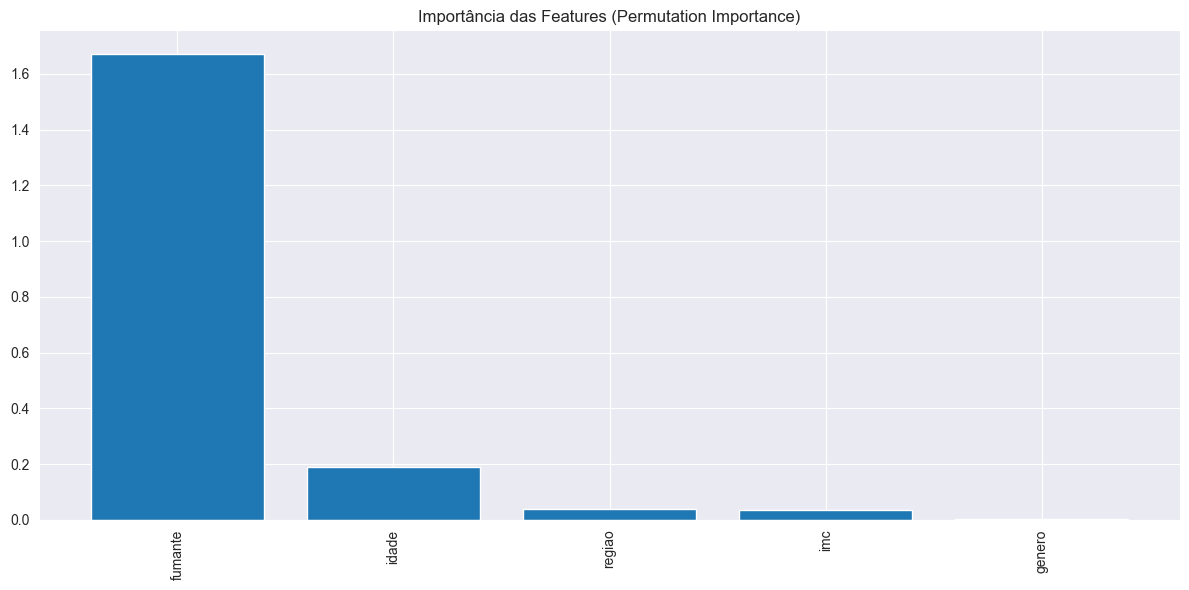

In [16]:
from sklearn.inspection import permutation_importance

# Análise de importância de features
# Obtendo nomes das features após one-hot encoding
categorical_features = ['genero', 'fumante', 'regiao']
numeric_features = ['idade', 'imc']
# Calculando importância das features usando permutation importance
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42
)

# Obtendo importâncias e seus índices ordenados
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Obtendo nomes das features transformadas
preprocessor = pipeline.named_steps['preprocessor']
transformed_X_train = preprocessor.transform(X_train)

# Obtendo nomes das features após transformação
transformed_feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        transformed_feature_names.extend(numeric_features)
    elif name == 'cat':
        # Para features categóricas, precisamos obter os nomes após one-hot encoding
        encoder = transformer.named_steps['onehotencoder']
        for feature in categorical_features:
            categories = raw_dataset[feature].unique()
            # Excluindo a primeira categoria (drop='first')
            for category in categories[1:]:
                transformed_feature_names.append(f"{feature}_{category}")

# Visualizando importância das features
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [X_train.columns.tolist()[i] for i in indices], rotation=90)
plt.title('Importância das Features (Permutation Importance)')
plt.tight_layout()
plt.show()

In [17]:
# Exemplo de novos dados para previsão
new_data = pd.DataFrame([
    [56, 0, 24.54, 0, 4],  # Homem, 56 anos, IMC 24.54, não fumante, sudeste
    [34, 1, 22.10, 1, 3],  # Mulher, 34 anos, IMC 22.10, fumante, centro-oeste
    [45, 0, 28.30, 0, 5],  # Homem, 45 anos, IMC 28.30, não fumante, sul
], columns=['idade', 'genero', 'imc', 'fumante', 'regiao'])

print("Novos dados para previsão:")
print(new_data)

predictions = best_pipeline.predict(new_data)

print("\nPrevisões de encargos médicos:")
for i, pred in enumerate(predictions):
    print(f"Pessoa {i + 1}: R$ {pred:.2f}")

Novos dados para previsão:
   idade  genero    imc  fumante  regiao
0     56       0  24.54        0       4
1     34       1  22.10        1       3
2     45       0  28.30        0       5

Previsões de encargos médicos:
Pessoa 1: R$ 9417.19
Pessoa 2: R$ 21273.96
Pessoa 3: R$ 8543.64
